### Лабораторна робота 2
### «Вирішення проблеми класифікації»
### дисципліна: «Побудова моделей машинного навчання»
### Виконала: студентка групи КС42 Гребенюк Єлизавета Миколаївна

#### Розв’язання проблеми класифікації типів зірок
#### Датасет: [Star Type Classification / NASA](https://www.kaggle.com/datasets/brsdincer/star-type-classification)

#### 1. Попередня обробка та візуалізація даних

##### Імпорт необхідних бібліотек

In [85]:
# Basic
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.model_selection import GridSearchCV

# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Support Vector Classifier
from sklearn.svm import SVC

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier

##### Завантаження даних

In [7]:
df = pd.read_csv("Stars.csv")
df.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


##### Візуалізація даних

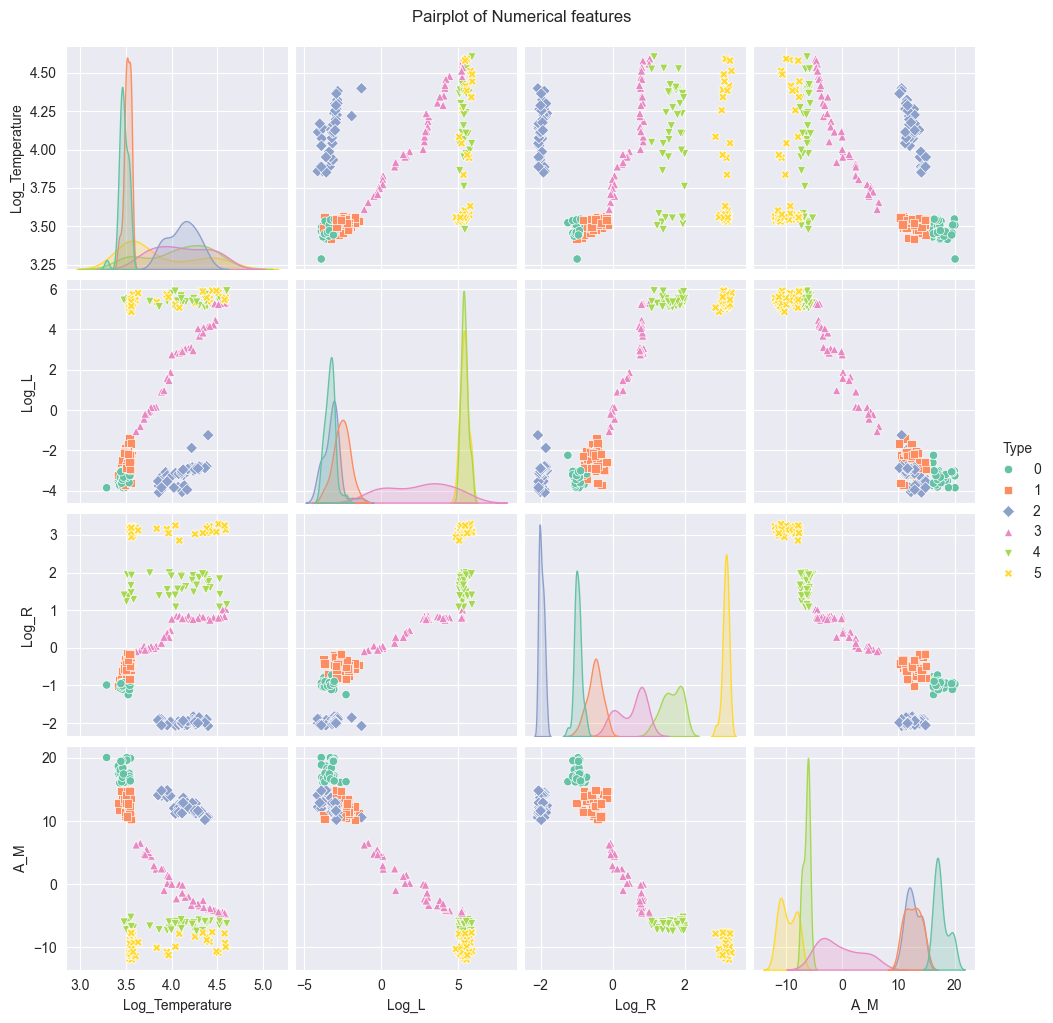

In [49]:
df_log = df.copy()

# Apply log10 to numerical columns
log_cols = ['Temperature', 'L', 'R']
for col in log_cols:
    df_log[f'Log_{col}'] = np.log10(df_log[col])

plot_cols = [f'Log_{col}' for col in log_cols] + ['A_M', 'Type']

sns.pairplot(df_log[plot_cols], hue='Type', palette='Set2',
             markers=["o", "s", "D", "^", "v", "X"])
plt.suptitle("Pairplot of Numerical features", y=1.02)
plt.show()

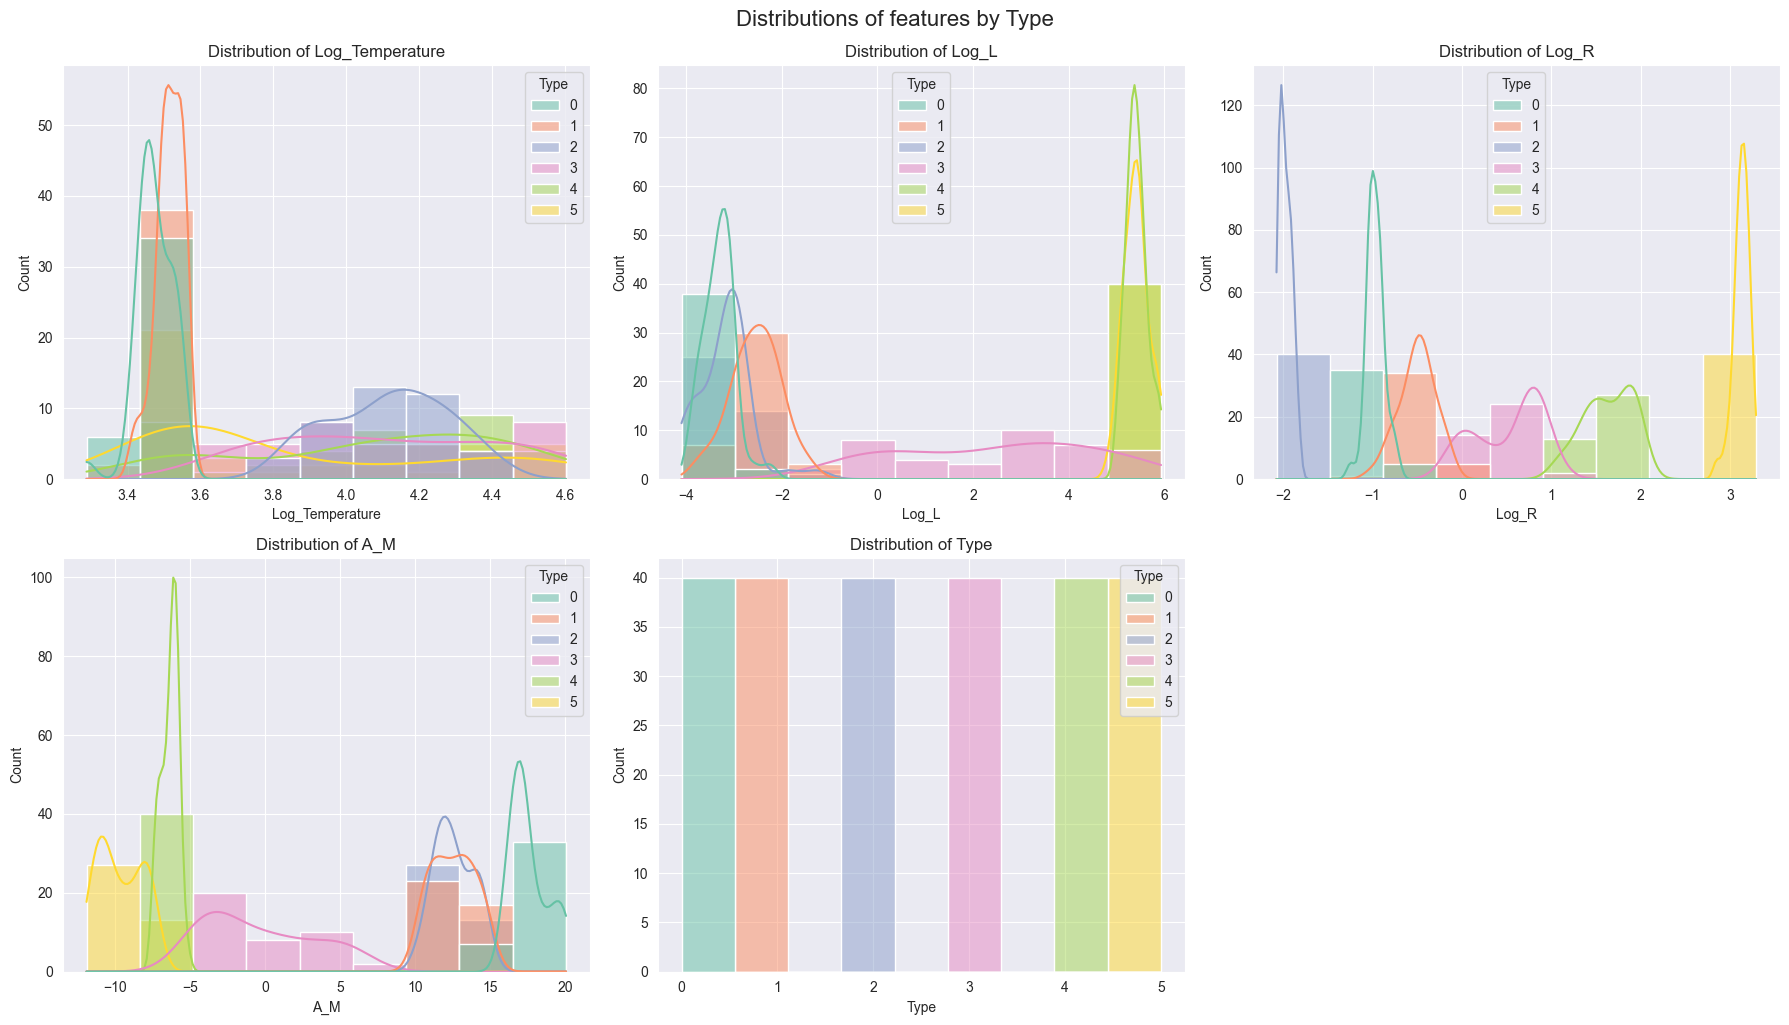

In [50]:
log_plot_cols = ['Log_Temperature', 'Log_L', 'Log_R', 'A_M', 'Type']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(log_plot_cols):
    sns.histplot(data=df_log, x=col, kde=True, hue='Type', palette='Set2', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

for j in range(len(log_plot_cols), 6):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("Distributions of features by Type", y=1.02, fontsize=16)
plt.show()

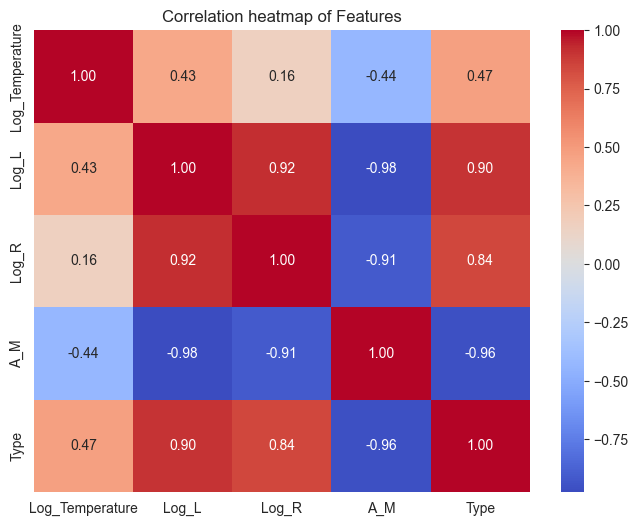

In [51]:
log_numeric_cols = ['Log_Temperature', 'Log_L', 'Log_R', 'A_M','Type']

plt.figure(figsize=(8, 6))
sns.heatmap(df_log[log_numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation heatmap of Features')
plt.show()

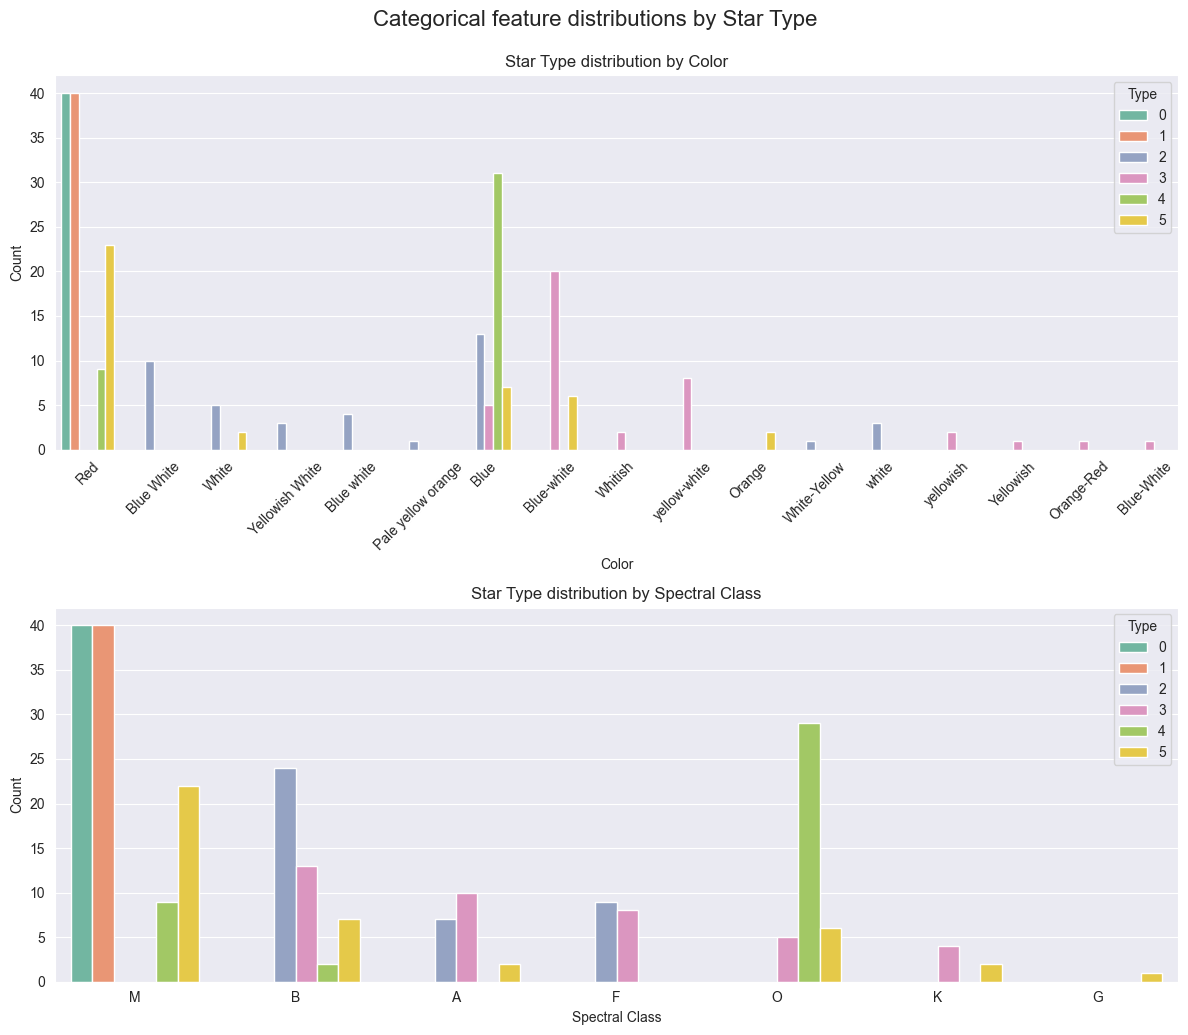

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Color vs Type
sns.countplot(data=df, x='Color', hue='Type', palette='Set2', ax=axes[0])
axes[0].set_title('Star Type distribution by Color')
axes[0].set_xlabel('Color')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Spectral_Class vs Type
sns.countplot(data=df, x='Spectral_Class', hue='Type', palette='Set2', ax=axes[1])
axes[1].set_title('Star Type distribution by Spectral Class')
axes[1].set_xlabel('Spectral Class')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.suptitle("Categorical feature distributions by Star Type", y=1.03, fontsize=16)
plt.show()

##### Підготовка даних

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
 6   Type            240 non-null    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 13.3+ KB


In [9]:
# Check for missing values
df.isnull().sum()

Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
Type              0
dtype: int64

In [10]:
# Check for duplicated rows
df.duplicated().sum()

np.int64(0)

In [55]:
X = df.drop(columns=['Type']).copy()
y = df['Type']

# Apply log10 to numeric columns
log_transform_cols = ['Temperature', 'L', 'R']
for col in log_transform_cols:
    X[col] = np.log10(X[col])

# One-hot encode categorical columns
categorical_cols = ['Color', 'Spectral_Class']
X_encoded = pd.get_dummies(X, columns=categorical_cols)

# Scale all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=8418
)

# Check the shape of the splits
X_train.shape, X_test.shape

((192, 28), (48, 28))

In [58]:
# Preview the transformed dataset
feature_names = X_encoded.columns
X_train_df = pd.DataFrame(X_train, columns=feature_names)

X_train_df.head()


,Temperature,L,R,A_M,Color_Blue,Color_Blue White,Color_Blue white,Color_Blue-White,Color_Blue-white,Color_Orange,...,Color_white,Color_yellow-white,Color_yellowish,Spectral_Class_A,Spectral_Class_B,Spectral_Class_F,Spectral_Class_G,Spectral_Class_K,Spectral_Class_M,Spectral_Class_O
0,0.309359,1.243957,0.628502,-0.986856,1.812654,-0.208514,-0.130189,-0.064685,-0.348562,-0.09167,...,-0.112509,-0.185695,-0.09167,-0.293211,-0.486943,-0.276104,-0.064685,-0.160128,-0.927613,2.236068
1,0.346435,-1.024810,-1.327656,0.913140,-0.551677,4.795832,-0.130189,-0.064685,-0.348562,-0.09167,...,-0.112509,-0.185695,-0.09167,3.410510,-0.486943,-0.276104,-0.064685,-0.160128,-0.927613,-0.447214
2,-0.357209,-0.236683,-0.203150,0.105380,-0.551677,-0.208514,-0.130189,-0.064685,-0.348562,-0.09167,...,-0.112509,5.385165,-0.09167,-0.293211,-0.486943,3.621829,-0.064685,-0.160128,-0.927613,-0.447214
3,-1.167608,-0.993226,-0.678857,0.704017,-0.551677,-0.208514,-0.130189,-0.064685,-0.348562,-0.09167,...,-0.112509,-0.185695,-0.09167,-0.293211,-0.486943,-0.276104,-0.064685,-0.160128,1.078036,-0.447214
4,-0.828728,-0.908339,-0.525472,0.946440,-0.551677,-0.208514,-0.130189,-0.064685,-0.348562,-0.09167,...,-0.112509,-0.185695,-0.09167,-0.293211,-0.486943,-0.276104,-0.064685,-0.160128,1.078036,-0.447214


#### 2. Random Forest Classifier

Random Forest Classifier
Train accuracy: 1.0000
Test accuracy:  0.9792
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         6
           4       0.89      1.00      0.94         8
           5       1.00      0.92      0.96        13

    accuracy                           0.98        48
   macro avg       0.98      0.99      0.98        48
weighted avg       0.98      0.98      0.98        48



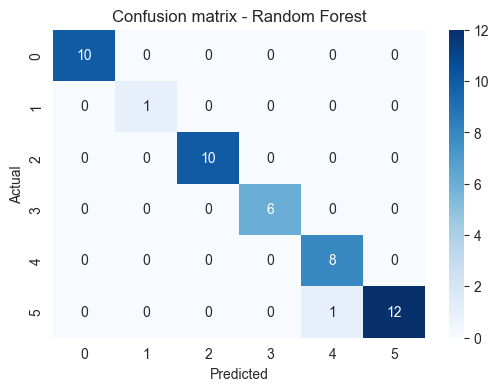

In [65]:
# Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)
y_train_rf = rf_model.predict(X_train)

# Accuracy
train_acc_rf = accuracy_score(y_train, y_train_rf)
test_acc_rf = accuracy_score(y_test, y_pred_rf)

# Evaluation
print("Random Forest Classifier")
print(f"Train accuracy: {train_acc_rf:.4f}")
print(f"Test accuracy:  {test_acc_rf:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### 3. Support Vector Classifier (SVC)

Support Vector Classifier (SVC)
Train Accuracy: 0.9948
Test Accuracy:  0.9792
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         6
           4       0.89      1.00      0.94         8
           5       1.00      0.92      0.96        13

    accuracy                           0.98        48
   macro avg       0.98      0.99      0.98        48
weighted avg       0.98      0.98      0.98        48



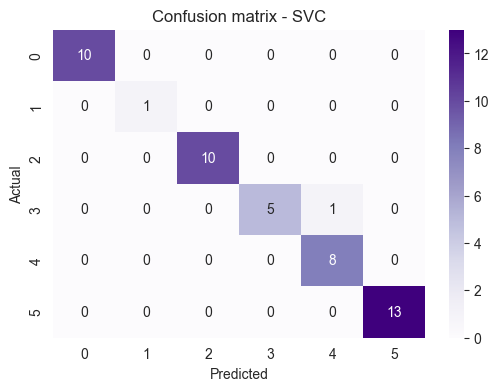

In [82]:
# Model
svc_model = SVC(kernel='linear', random_state=42)
svc_model.fit(X_train, y_train)

y_pred_svc = svc_model.predict(X_test)
y_train_svc = svc_model.predict(X_train)

train_acc_svc = accuracy_score(y_train, y_train_svc)
test_acc_svc = accuracy_score(y_test, y_pred_svc)

# Evaluation
print("Support Vector Classifier (SVC)")
print(f"Train Accuracy: {train_acc_svc:.4f}")
print(f"Test Accuracy:  {test_acc_svc:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

# Confusion Matrix
cm_svc = confusion_matrix(y_test, y_pred_svc)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion matrix - SVC')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### 4. Gradient Boosting Classifier

Gradient Boosting Classifier
Train Accuracy: 1.0000
Test Accuracy:  1.0000
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        13

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



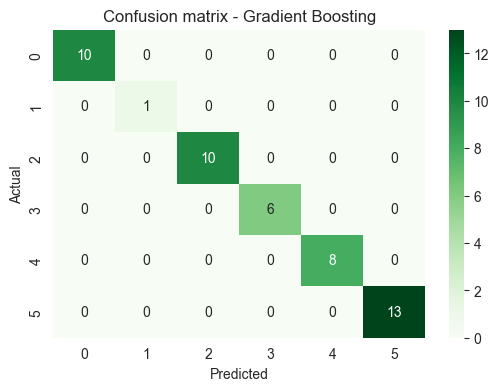

In [67]:
# Model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
y_train_gb = gb_model.predict(X_train)

train_acc_gb = accuracy_score(y_train, y_train_gb)
test_acc_gb = accuracy_score(y_test, y_pred_gb)

# Evaluation
print("Gradient Boosting Classifier")
print(f"Train Accuracy: {train_acc_gb:.4f}")
print(f"Test Accuracy:  {test_acc_gb:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred_gb))

# Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion matrix - Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Порівняння класифікаторів

In [88]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'SVC', 'Gradient Boosting'],
    'Train Accuracy': [train_acc_rf, train_acc_svc, train_acc_gb],
    'Test Accuracy': [test_acc_rf, test_acc_svc, test_acc_gb]
})

print("Model performance comparison:")
results = results.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
display(results)

best_model_name = results.loc[0, 'Model']
best_test_acc = results.loc[0, 'Test Accuracy']

print(f"The best classifier is {best_model_name}, as it achieved the highest test accuracy: {best_test_acc:.4f}.")

Model performance comparison:


,Model,Train Accuracy,Test Accuracy
0,Gradient Boosting,1.000000,1.000000
1,Random Forest,1.000000,0.979167
2,SVC,0.994792,0.979167


The best classifier is Gradient Boosting, as it achieved the highest test accuracy: 1.0000.


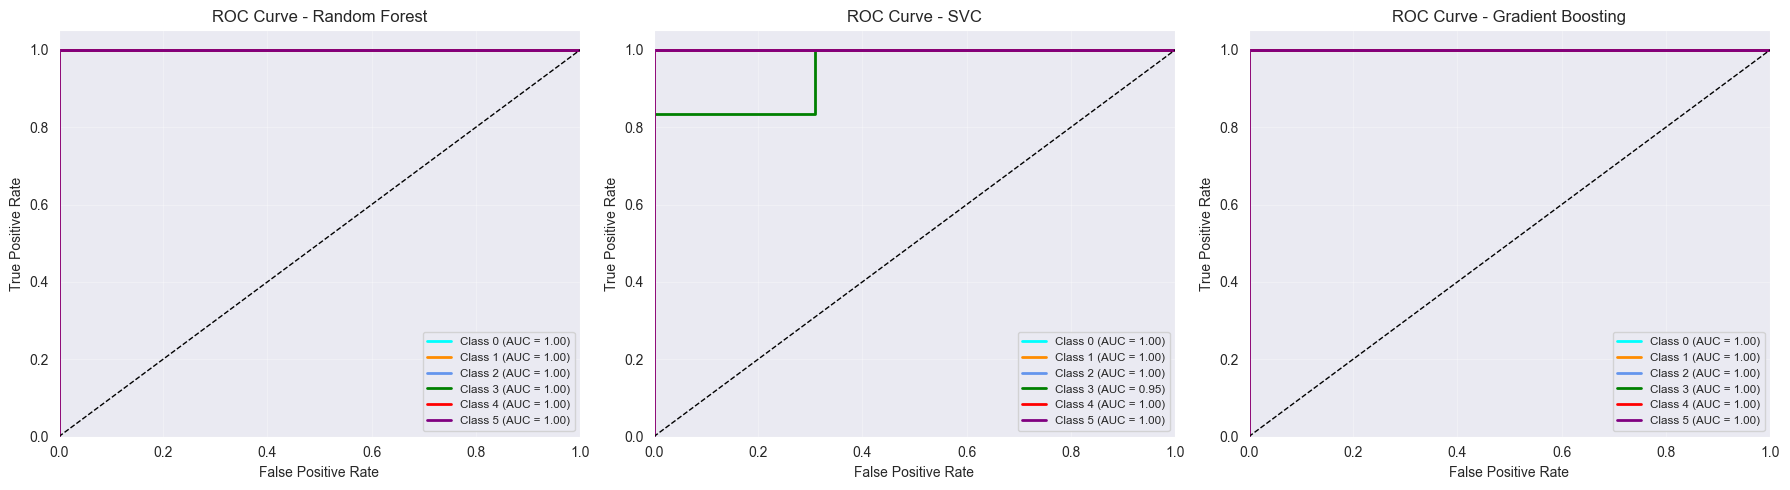

In [84]:
n_classes = len(set(y))
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models_prob = {
    "Random Forest": rf_model,
    "SVC": svc_model,
    "Gradient Boosting": gb_model
}
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])

for ax, (model_name, model) in zip(axes, models_prob.items()):
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        print(f"{model_name} does not support ROC curve.")
        continue

    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=color, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {model_name}')
    ax.legend(loc="lower right", fontsize='small')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### 5. Підбір гіперпараметрів для SVC

In [94]:
# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['linear', 'rbf','poly', 'sigmoid'],
}
svc = SVC(probability=True)

# Perform grid search with 5-fold cross-validation and accuracy scoring
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters from GridSearchCV:")
print(grid_search.best_params_)

Best parameters from GridSearchCV:
{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


Optimized SVC results
Train accuracy: 0.9948
Test accuracy:  1.0000
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        13

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



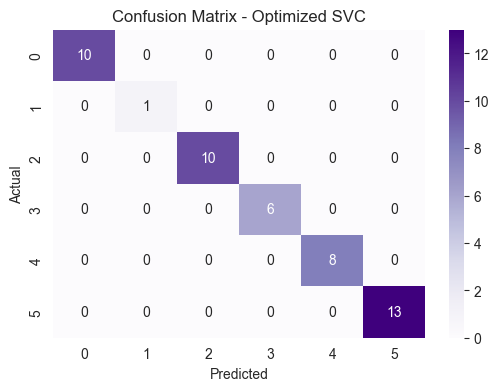

In [95]:
# Get the best estimator from grid search
best_svc = grid_search.best_estimator_

y_pred_best_svc = best_svc.predict(X_test)
y_train_pred_best = best_svc.predict(X_train)

train_acc_best = accuracy_score(y_train, y_train_pred_best)
test_acc_best = accuracy_score(y_test, y_pred_best_svc)

print(f"Optimized SVC results")
print(f"Train accuracy: {train_acc_best:.4f}")
print(f"Test accuracy:  {test_acc_best:.4f}")
print("Classification report:")
print(classification_report(y_test, y_pred_best_svc, zero_division=0))

cm_best_svc = confusion_matrix(y_test, y_pred_best_svc)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best_svc, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix - Optimized SVC')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### Порівняння класифікаторів після підбору параметрів SVC

In [96]:
results = pd.DataFrame({
    'Model': ['Random Forest','SVC (Before Tuning)','Gradient Boosting','SVC (After Tuning)'],
    'Train Accuracy': [train_acc_rf,train_acc_svc,train_acc_gb,train_acc_best],
    'Test Accuracy': [test_acc_rf,test_acc_svc,test_acc_gb,test_acc_best  ]
})

# Sort and display
print("Final model performance comparison:")
results = results.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
display(results)

max_test_acc = results['Test Accuracy'].max()
best_models = results[results['Test Accuracy'] == max_test_acc]['Model'].tolist()

if len(best_models) == 1:
    print(f"The best classifier is **{best_models[0]}**, as it achieved the highest test accuracy: {max_test_acc:.4f}.")
else:
    model_list = ', '.join([f"{m}" for m in best_models])
    print(f"The best classifiers are {model_list}, as they both achieved the highest test accuracy: {max_test_acc:.4f}.")

Final model performance comparison:


,Model,Train Accuracy,Test Accuracy
0,SVC (After Tuning),0.994792,1.000000
1,Gradient Boosting,1.000000,1.000000
2,SVC (Before Tuning),0.994792,0.979167
3,Random Forest,1.000000,0.979167


The best classifiers are SVC (After Tuning), Gradient Boosting, as they both achieved the highest test accuracy: 1.0000.


> **Висновок**: у цій роботі було проведено повний цикл класифікації типів зірок за їхніми фізичними та спектральними характеристиками. Після попередньої обробки даних (логарифмізація, one-hot кодування, масштабування) було досліджено ефективність кількох моделей машинного навчання. Серед протестованих алгоритмів найвищу точність на тестових даних (100%) продемонстрували: Gradient Boosting Classifier, Support Vector Classifier (після оптимізації гіперпараметрів). Це свідчить про те, що обрані ознаки добре відображають відмінності між класами, а сама задача є достатньо визначеною. Інші моделі — Random Forest та базовий SVC — також показали високу якість передбачень (≈97.9%). Отже, обидві моделі — Gradient Boosting і оптимізований SVC — є ефективними рішеннями для даної задачі.